<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Sentinel-1 product processing with ISCE
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to identify anomalies, such as Earth surface deformations, in InSAR interferograms using machine learning.

Out goal here is to download and pre-process a set of interferograms for two areas, one where the 2018 Oaxaca earthquake (Mexico) occured, and one where the 2017 Puebla earthquake (Mexico) occured.

# Package imports

In [1]:
%matplotlib notebook

import os
import math
from getpass import getpass
import matplotlib.pyplot as plt
from glob import glob
import datetime

from pyinsar.processing.utilities.generic import sorted_alphanumeric
from pyinsar.data_import.sentinel import *
from pyinsar.processing.isce.input_file import *
from pyinsar.data_import.import_georaster import *
from pyinsar.data_import.import_raster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.output.export_georaster import *
from pyinsar.output.plot_raster import *

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from skdaccess.utilities.srtm_util import merge_srtm_tiles

# Product download and processing setup

Enter the username and password for your [Earthdata](https://earthdata.nasa.gov/) account, to recover the data from NASA repositories

In [15]:
username = 'grongier'
password = getpass()

········


Define the folders that contain the input data and that will contain the output files

In [3]:
base_folder = '/data/insar/mexico_case_studies/'

case_folder = '2018_Oaxaca_Earthquake/'
# case_folder = '2017_Puebla_Earthquake/'

result_folder = base_folder + case_folder
data_folder = result_folder + 'Data/'
orbit_folder = base_folder + 'Precise_Orbits/'
aux_folder = base_folder + 'Calibration_Data/'

In [4]:
os.makedirs(data_folder, exist_ok = True)

Download the Sentinel-1 products from Alaska Satellite Facility's data portal, Vertex

[scihub.copernicus.eu/dhus/#/home](https://scihub.copernicus.eu/dhus/#/home)

( footprint:"Intersects(POLYGON((-98.13233001478302 16.001729417320718,-98.00739861592939 16.77222835695966,-96.81162665547332 16.63547446309549,-96.99010008240708 15.967414836087855,-98.13233001478302 16.001729417320718,-98.13233001478302 16.001729417320718)))") AND   (platformname:Sentinel-1 AND filename:S1B_* AND producttype:SLC AND sensoroperationalmode:IW AND relativeorbitnumber:5)

In [16]:
# Oaxaca

# Earthquake
# product_names = ['S1B_IW_SLC__1SDV_20180205T003836_20180205T003906_009481_0110E0_6407',
#                  'S1B_IW_SLC__1SDV_20180217T003836_20180217T003906_009656_0116A5_DDE3']

product_names = ['S1B_IW_SLC__1SDV_20170926T003839_20170926T003908_007556_00D572_502A',
                 'S1B_IW_SLC__1SDV_20171008T003839_20171008T003909_007731_00DA7A_A69E',
                 'S1B_IW_SLC__1SDV_20171020T003839_20171020T003909_007906_00DF71_633C',
                 'S1B_IW_SLC__1SDV_20171101T003839_20171101T003909_008081_00E479_26BE',
                 'S1B_IW_SLC__1SDV_20171113T003839_20171113T003909_008256_00E9A4_4885',
                 'S1B_IW_SLC__1SDV_20171125T003838_20171125T003908_008431_00EEF4_F0E1',
                 'S1B_IW_SLC__1SDV_20171207T003838_20171207T003908_008606_00F486_D789',
                 'S1B_IW_SLC__1SDV_20171219T003838_20171219T003907_008781_00FA1A_9002',
                 'S1B_IW_SLC__1SDV_20171231T003837_20171231T003907_008956_00FFB4_4576',
                 'S1B_IW_SLC__1SDV_20180112T003837_20180112T003907_009131_01056C_75D3',
                 'S1B_IW_SLC__1SDV_20180205T003836_20180205T003906_009481_0110E0_6407',
                 'S1B_IW_SLC__1SDV_20180217T003836_20180217T003906_009656_0116A5_DDE3',
                 'S1B_IW_SLC__1SDV_20180301T003836_20180301T003906_009831_011C71_5319',
                 'S1B_IW_SLC__1SDV_20180325T003836_20180325T003906_010181_0127F7_6D4C',
                 'S1B_IW_SLC__1SDV_20180406T003836_20180406T003906_010356_012DA9_7072',
                 'S1B_IW_SLC__1SDV_20180418T003837_20180418T003906_010531_013340_41E2',
                 'S1B_IW_SLC__1SDV_20180430T003837_20180430T003907_010706_0138DC_981D',
                 'S1B_IW_SLC__1SDV_20180512T003838_20180512T003908_010881_013E83_6C83',
                 'S1B_IW_SLC__1SDV_20180524T003839_20180524T003909_011056_014436_9D43',
                 'S1B_IW_SLC__1SDV_20180605T003839_20180605T003909_011231_0149D8_F970',
                 'S1B_IW_SLC__1SDV_20180617T003840_20180617T003910_011406_014F30_E196',
                 'S1B_IW_SLC__1SDV_20180629T003841_20180629T003911_011581_0154A3_D918',
                 'S1B_IW_SLC__1SDV_20180711T003841_20180711T003911_011756_015A0E_525A',
                 'S1B_IW_SLC__1SDV_20180723T003842_20180723T003912_011931_015F66_A839',
                 'S1B_IW_SLC__1SDV_20180804T003843_20180804T003913_012106_0164AA_A2E7']

# Puebla

# Earthquake
# product_names = ['S1A_IW_SLC__1SDV_20170917T122603_20170917T122630_018415_01F017_BE33',
#                  'S1A_IW_SLC__1SDV_20170929T122603_20170929T122630_018590_01F56D_0418']

# product_names = ['S1A_IW_SLC__1SDV_20170225T122554_20170225T122620_015440_019589_8457',
#                  'S1A_IW_SLC__1SDV_20170309T122554_20170309T122621_015615_019AD5_488D',
#                  'S1A_IW_SLC__1SDV_20170321T122554_20170321T122621_015790_01A00C_4656',
#                  'S1A_IW_SLC__1SDV_20170402T122554_20170402T122621_015965_01A53C_B268',
#                  'S1A_IW_SLC__1SDV_20170414T122555_20170414T122622_016140_01AA90_4522',
#                  'S1A_IW_SLC__1SDV_20170426T122555_20170426T122622_016315_01AFEB_40DF',
#                  'S1A_IW_SLC__1SDV_20170508T122556_20170508T122623_016490_01B53B_2119',
#                  'S1A_IW_SLC__1SDV_20170520T122557_20170520T122623_016665_01BA94_4698',
#                  'S1A_IW_SLC__1SDV_20170601T122557_20170601T122624_016840_01BFF9_161A',
#                  'S1A_IW_SLC__1SDV_20170613T122558_20170613T122625_017015_01C568_B8FF',
#                  'S1A_IW_SLC__1SDV_20170625T122559_20170625T122626_017190_01CABF_9A3F',
#                  'S1A_IW_SLC__1SDV_20170707T122559_20170707T122626_017365_01D000_A0DD',
#                  'S1A_IW_SLC__1SDV_20170719T122600_20170719T122627_017540_01D55B_DCC1',
#                  'S1A_IW_SLC__1SDV_20170731T122601_20170731T122628_017715_01DAB5_7842',
#                  'S1A_IW_SLC__1SDV_20170812T122601_20170812T122628_017890_01E005_3BAD',
#                  'S1A_IW_SLC__1SDV_20170824T122602_20170824T122629_018065_01E54F_2660',
#                  'S1A_IW_SLC__1SDV_20170905T122602_20170905T122629_018240_01EAA3_1EA9',
#                  'S1A_IW_SLC__1SDV_20170917T122603_20170917T122630_018415_01F017_BE33',
#                  'S1A_IW_SLC__1SDV_20170929T122603_20170929T122630_018590_01F56D_0418',
#                  'S1A_IW_SLC__1SDV_20171011T122603_20171011T122630_018765_01FABD_CA1F',
#                  'S1A_IW_SLC__1SDV_20171023T122603_20171023T122630_018940_02001F_83D2',
#                  'S1A_IW_SLC__1SDV_20171104T122603_20171104T122630_019115_020575_8A3C',
#                  'S1A_IW_SLC__1SDV_20171116T122603_20171116T122630_019290_020AEA_3C0F',
#                  'S1A_IW_SLC__1SDV_20171128T122603_20171128T122630_019465_021073_BB4D',
#                  'S1A_IW_SLC__1SDV_20171210T122602_20171210T122629_019640_0215E9_8A90',
#                  'S1A_IW_SLC__1SDV_20171222T122602_20171222T122629_019815_021B4B_AA03',
#                  'S1A_IW_SLC__1SDV_20180103T122601_20180103T122628_019990_0220D0_D017',
#                  'S1A_IW_SLC__1SDV_20180115T122601_20180115T122628_020165_02265C_FCC8',
#                  'S1A_IW_SLC__1SDV_20180127T122601_20180127T122628_020340_022BE7_2137',
#                  'S1A_IW_SLC__1SDV_20180220T122600_20180220T122627_020690_023710_AD11',
#                  'S1A_IW_SLC__1SDV_20180304T122600_20180304T122627_020865_023C9A_2E81',
#                  'S1A_IW_SLC__1SDV_20180316T122600_20180316T122627_021040_024227_4037',
#                  'S1A_IW_SLC__1SDV_20180328T122601_20180328T122627_021215_0247B7_4111',
#                  'S1A_IW_SLC__1SDV_20180409T122601_20180409T122628_021390_024D37_56CE',
#                  'S1A_IW_SLC__1SDV_20180421T122601_20180421T122628_021565_0252A8_0E22',
#                  'S1A_IW_SLC__1SDV_20180503T122602_20180503T122629_021740_025829_A840',
#                  'S1A_IW_SLC__1SDV_20180620T122605_20180620T122632_022440_026E28_DC98',
#                  'S1A_IW_SLC__1SDV_20180702T122605_20180702T122632_022615_027340_9FC7',
#                  'S1A_IW_SLC__1SDV_20180714T122606_20180714T122633_022790_02787B_B687']

In [17]:
product_names.sort()
product_paths = download_products(product_names,
                                  data_folder,
                                  username = username,
                                  password = password)

File S1B_IW_SLC__1SDV_20170926T003839_20170926T003908_007556_00D572_502A.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171008T003839_20171008T003909_007731_00DA7A_A69E.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171020T003839_20171020T003909_007906_00DF71_633C.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171101T003839_20171101T003909_008081_00E479_26BE.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171113T003839_20171113T003909_008256_00E9A4_4885.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171125T003838_20171125T003908_008431_00EEF4_F0E1.zip already exists in /data/insar/mexico_case_studies/2018_Oaxaca_Earthquake/Data/
File S1B_IW_SLC__1SDV_20171207T003838_20171207T003908_008606_00F

Download the precise orbits corresponding to the Sentinel-1 products, from the Alaska Satellite Facility too

In [18]:
precise_orbit_paths = download_precise_orbits(data_folder, orbit_folder, username, password)

File S1B_OPER_AUX_POEORB_OPOD_20171215T110856_V20171124T225942_20171126T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20180321T110558_V20180228T225942_20180302T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20180601T110611_V20180511T225942_20180513T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20171227T110853_V20171206T225942_20171208T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20180306T110559_V20180213T225942_20180215T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20180508T110553_V20180417T225942_20180419T005942.EOF already exists in /data/insar/mexico_case_studies/Precise_Orbits/
File S1B_OPER_AUX_POEORB_OPOD_20180120T111008_V20171230T225942_20180101T005942.EOF already exists in /data

Create the directories and files to process the pairs of Sentinel-1 products with ISCE

In [19]:
topsApp_paths = prepare_topsApps(product_paths,
                                 result_folder,
                                 orbit_path = orbit_folder,
                                 auxiliary_data_path = aux_folder)

# Processing

Open a terminal and for each topsApp path (i.e., for each pair of Sentinel-1 product):
```
$ cd  path_to_topsApp.xml
$ topsApp.py
```

# Getting atmospheric delay models

Go to [ceg-research.ncl.ac.uk/v2/gacos](http://ceg-research.ncl.ac.uk/v2/gacos/)

In [20]:
georaster = open_georaster(result_folder + 'Pair_1/merged/filt_topophase.unw.geo.vrt')
georaster_extent = get_georaster_extent(georaster)

print('Lon min:', math.floor(georaster_extent[0]),
      '| Lon max:', math.ceil(georaster_extent[1]),
      '| Lat min:', math.floor(georaster_extent[2]),
      '| Lat max:', math.ceil(georaster_extent[3]))

Lon min: -99 | Lon max: -96 | Lat min: 15 | Lat max: 18


In [21]:
mean_time_of_interest = datetime.timedelta(0, 0, 0)

for product_name in product_names:
    product_time_start = product_name[26:32]
    product_time_start = datetime.timedelta(hours = int(product_time_start[0:2]),
                                            minutes = int(product_time_start[2:4]),
                                            seconds = int(product_time_start[4:6]))
    product_time_end = product_name[42:48]
    product_time_end = datetime.timedelta(hours = int(product_time_end[0:2]),
                                          minutes = int(product_time_end[2:4]),
                                          seconds = int(product_time_end[4:6]))
    mean_time_of_interest += product_time_end - (product_time_end - product_time_start)/2
    
mean_time_of_interest /= len(product_names)
print('Mean time of interest:', mean_time_of_interest)

Mean time of interest: 0:38:53.340000


In [22]:
for i, product_name in enumerate(product_names):
    if i != 0 and i%10 == 0:
        print()
    product_date = product_name[17:25]
    print(product_date)

20170926
20171008
20171020
20171101
20171113
20171125
20171207
20171219
20171231
20180112

20180205
20180217
20180301
20180325
20180406
20180418
20180430
20180512
20180524
20180605

20180617
20180629
20180711
20180723
20180804


# Creating interferogram stack

In [23]:
wavelength = 5.6 # cm
k = 2

grid_yx_spacing = (90., 90.)

In [24]:
base_folder = '/data/insar/mexico_case_studies/'

case_folder = '2018_Oaxaca_Earthquake/'
exclude_pairs = []
exclude_last_models = 0

# case_folder = '2017_Puebla_Earthquake/'
# exclude_pairs = ['36', '37', '38']
# exclude_last_models = 3

data_folder = base_folder + case_folder

In [25]:
data_paths = glob(data_folder + 'Pair_*/')
data_paths = sorted_alphanumeric(data_paths)

model_paths = glob(data_folder + 'GACOS_Tropospheric_Delays/*.ztd.rsc')
model_paths = sorted_alphanumeric(model_paths)

The extent and location of each interferogram vary due to orbital and processing errors. We need to define a shared extent to be able to stack all the interferograms into a single NumPy array.

In [26]:
data_latlon_extent = []

for i in range(len(data_paths)):
    pair_number = data_paths[i].split('/')[-2].split('_')[-1]
    if pair_number not in exclude_pairs:
        georaster = open_georaster(data_paths[i] + 'merged/filt_topophase.unw.geo.vrt')
        data_latlon_extent.append(get_georaster_extent(georaster))
        
data_latlon_extent = np.array(data_latlon_extent)
data_latlon_extent = [np.min(data_latlon_extent[:, 0]), np.max(data_latlon_extent[:, 1]),
                      np.min(data_latlon_extent[:, 2]), np.max(data_latlon_extent[:, 3])]

In [27]:
old_projection_wkt = open_georaster(data_paths[0] + 'merged/filt_topophase.unw.geo.vrt').GetProjectionRef()
new_projection_utm = find_utm_area(data_latlon_extent[0],
                                   data_latlon_extent[2])

x_min, y_min, _  = reproject_point(data_latlon_extent[0],
                                   data_latlon_extent[2],
                                   old_projection_wkt = old_projection_wkt,
                                   new_projection_utm = new_projection_utm)
x_max, y_max, _  = reproject_point(data_latlon_extent[1],
                                   data_latlon_extent[3],
                                   old_projection_wkt = old_projection_wkt,
                                   new_projection_utm = new_projection_utm)

data_extent = (x_min, x_max, y_min, y_max)

We project the unwrapped interferograms into the common extent, and then project them into a UTM coordinate system.

In [28]:
%%time

unw_data_array = []
unw_data_geotransforms = []
unw_data_projections = []

for i in range(len(data_paths)):
    pair_number = data_paths[i].split('/')[-2].split('_')[-1]
    if pair_number not in exclude_pairs:
        georaster = open_georaster(data_paths[i] + 'merged/filt_topophase.unw.geo.vrt')

        georaster = reproject_georaster(georaster,
                                        grid_yx_spacing,
                                        new_projection_utm = new_projection_utm,
                                        new_extent = data_extent)
        georaster_array = get_georaster_array(georaster)
        georaster_array[:, georaster_array[0] == 0.] = np.nan
        georaster_array = -georaster_array[1]*wavelength/(2*k*np.pi)

        unw_data_array.append(georaster_array)
        unw_data_geotransforms.append(georaster.GetGeoTransform())
        unw_data_projections.append(georaster.GetProjection())
        
unw_data_array = np.array(unw_data_array)

CPU times: user 11min 11s, sys: 4min 55s, total: 16min 7s
Wall time: 11min 43s


<IPython.core.display.Javascript object>


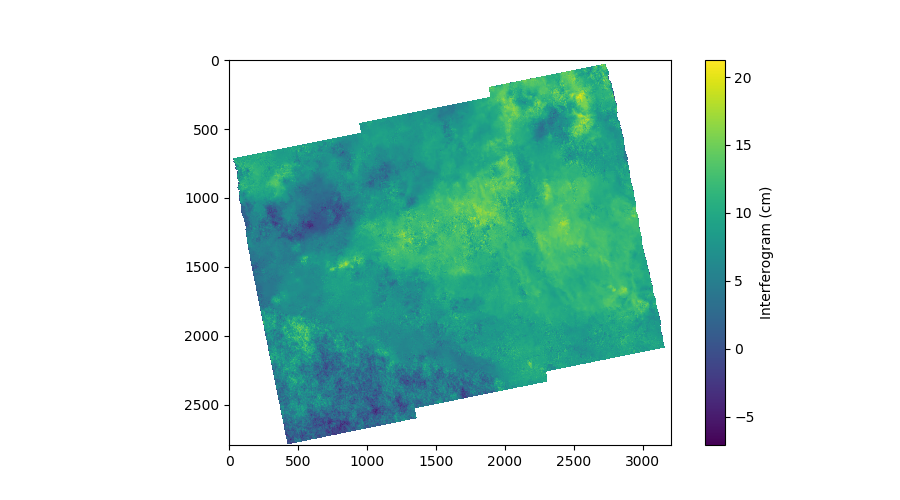

In [29]:
plot_interactive_slicing(unw_data_array,
                         0,
                         clabel = 'Interferogram (cm)',
                         update_colorbar = True,
                         figsize = (9, 5))

In [30]:
if (unw_data_geotransforms.count(unw_data_geotransforms[0]) == len(unw_data_geotransforms)
    and unw_data_projections.count(unw_data_projections[0]) == len(unw_data_projections)):
    print('True')
else:
    print('False')

True


In [31]:
georaster = create_georaster_from_array(unw_data_array,           
                                        unw_data_geotransforms[0], 
                                        unw_data_projections[0],
                                        file_type = 'GTiff',
                                        file_path = data_folder + 'Stacked_filt_topophase_unw_geo.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None

We do the same thing with the wrapped interferograms.

In [32]:
%%time

flat_data_array = []
flat_data_geotransforms = []
flat_data_projections = []

for i in range(len(data_paths)):
    pair_number = data_paths[i].split('/')[-2].split('_')[-1]
    if pair_number not in exclude_pairs:
        georaster = open_georaster(data_paths[i] + 'merged/filt_topophase.flat.geo.vrt')
        georaster_array = get_georaster_array(georaster, as_float = False)
        georaster_array = np.angle(georaster_array)
        georaster = create_georaster_from_array(georaster_array,           
                                                georaster.GetGeoTransform(), 
                                                georaster.GetProjection())
        
        georaster = reproject_georaster(georaster,
                                        grid_yx_spacing,
                                        new_projection_utm = new_projection_utm,
                                        new_extent = data_extent)
        georaster_array = get_georaster_array(georaster)
        georaster_array[np.isnan(unw_data_array[i])] = np.nan

        flat_data_array.append(georaster_array)
        flat_data_geotransforms.append(georaster.GetGeoTransform())
        flat_data_projections.append(georaster.GetProjection())
        
flat_data_array = np.array(flat_data_array)

CPU times: user 8min 28s, sys: 6min 19s, total: 14min 48s
Wall time: 10min 57s


<IPython.core.display.Javascript object>


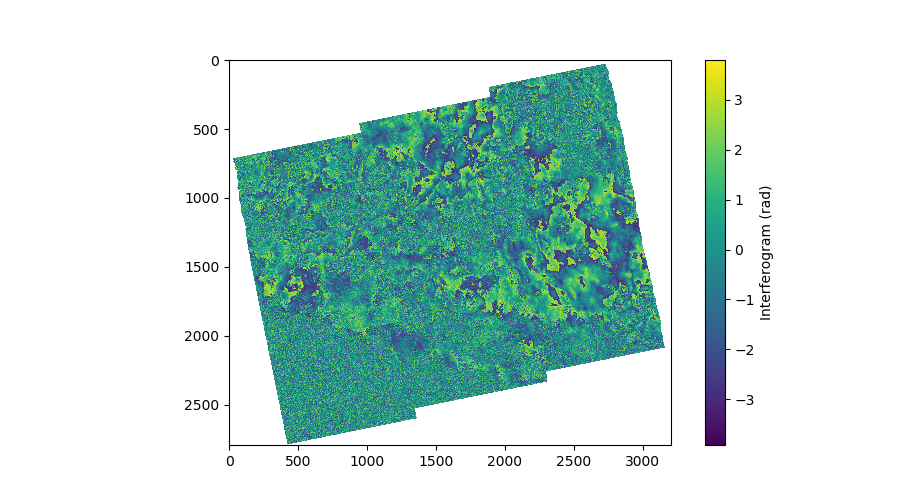

In [33]:
plot_interactive_slicing(flat_data_array,
                         0,
                         clabel = 'Interferogram (rad)',
                         update_colorbar = True,
                         figsize = (9, 5))

In [34]:
if (flat_data_geotransforms.count(flat_data_geotransforms[0]) == len(flat_data_geotransforms)
    and flat_data_projections.count(flat_data_projections[0]) == len(flat_data_projections)):
    print('True')
else:
    print('False')

True


In [35]:
georaster = create_georaster_from_array(flat_data_array,           
                                        flat_data_geotransforms[0], 
                                        flat_data_projections[0],
                                        file_type = 'GTiff',
                                        file_path = data_folder + 'Stacked_filt_topophase_flat_geo.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None

Finally, we get the models of atmospheric delays and project them too.

In [36]:
%%time

tropodelay_array = []
tropodelay_extents = []

for i in range(len(model_paths) - 1 - exclude_last_models):
    if str(i + 1) not in exclude_pairs:
        tropodelay1_path = model_paths[i]
        tropodelay2_path = model_paths[i + 1]

        tropodelay1_array, tropodelay_extent = open_gacos_tropospheric_delays(tropodelay1_path)
        tropodelay2_array, tropodelay_extent = open_gacos_tropospheric_delays(tropodelay2_path)

        tropodelay_array.append(tropodelay2_array - tropodelay1_array)
        tropodelay_extents.append(tropodelay_extent)
        
tropodelay_array = np.array(tropodelay_array)*100. # cm
if tropodelay_extents.count(tropodelay_extents[0]) == len(tropodelay_extents):
    print('True')
else:
    print('False')
        
georaster = create_georaster_from_array(tropodelay_array,           
                                        (tropodelay_extents[0][0], (tropodelay_extents[0][1] - tropodelay_extents[0][0])/tropodelay_array.shape[-1], 0.,
                                         tropodelay_extents[0][3], 0., -(tropodelay_extents[0][3] - tropodelay_extents[0][2])/tropodelay_array.shape[-2]), 
                                        '''GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]''')
georaster = reproject_georaster(georaster,
                                grid_yx_spacing,
                                new_projection_utm = new_projection_utm,
                                new_extent = data_extent,
                                file_type = 'GTiff',
                                file_path = data_folder + 'Stacked_atmospheric_delay_model.tif',
                                options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
tropodelay_array = get_georaster_array(georaster)
georaster = None

True
CPU times: user 4min 23s, sys: 53.6 s, total: 5min 16s
Wall time: 3min 15s


<IPython.core.display.Javascript object>


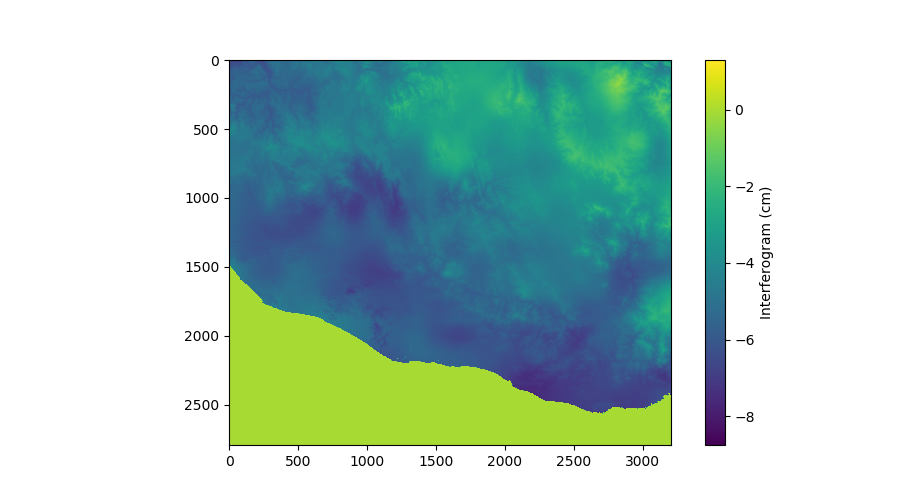

In [37]:
plot_interactive_slicing(tropodelay_array,
                         0,
                         clabel = 'Interferogram (cm)',
                         update_colorbar = True,
                         figsize = (9, 5))

If needed, we can also get the corresponding topography from SRTM data.

In [38]:
%%time

srtm_df = SRTM_DF(lat_tile_start = math.floor(data_latlon_extent[2]),
                  lat_tile_end = math.ceil(data_latlon_extent[3]) - 1,
                  lon_tile_start = math.floor(data_latlon_extent[0]),
                  lon_tile_end = math.ceil(data_latlon_extent[1]) - 1,
                  username = username, password = password)
srtm_tiles = srtm_df.output()
topography_array, topography_extent = merge_srtm_tiles(srtm_tiles,
                                                       math.floor(data_latlon_extent[0]),
                                                       math.ceil(data_latlon_extent[1]),
                                                       math.floor(data_latlon_extent[2]),
                                                       math.ceil(data_latlon_extent[3]))

georaster = create_georaster_from_array(topography_array,           
                                        (topography_extent[0], (topography_extent[1] - topography_extent[0])/topography_array.shape[-1], 0.,
                                         topography_extent[3], 0., -(topography_extent[3] - topography_extent[2])/topography_array.shape[-2]), 
                                        '''GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]''')
georaster = reproject_georaster(georaster,
                                grid_yx_spacing,
                                new_projection_utm = new_projection_utm,
                                new_extent = data_extent,
                                file_type = 'GTiff',
                                file_path = data_folder + 'topography.tif',
                                options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
topography_array = get_georaster_array(georaster)
georaster = None

CPU times: user 24.7 s, sys: 17.2 s, total: 41.9 s
Wall time: 40.3 s


<IPython.core.display.Javascript object>


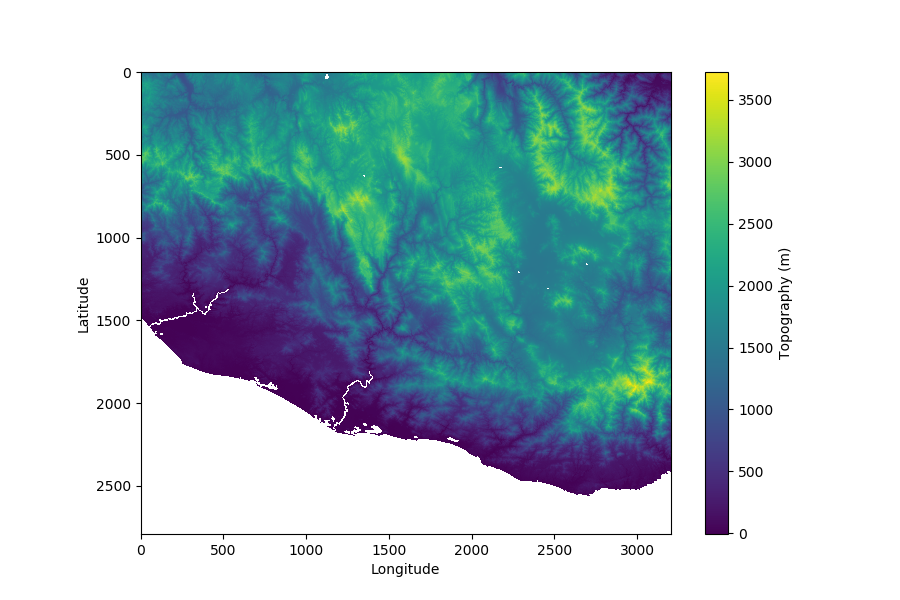

In [41]:
figure, subplot = plt.subplots(figsize = (9, 6))

image = plt.imshow(np.ma.masked_invalid(topography_array),
                   cmap = 'viridis', interpolation = 'None', rasterized = True,
                   zorder = 0)

image_colorbar = plt.colorbar(image)
image_colorbar.set_label('Topography (m)')

subplot.set_xlabel('Longitude')
subplot.set_ylabel('Latitude')
                
plt.show()

To ensure the consistency between the interferograms, we can spatially referenced all of them relative to the same location.

In [42]:
georaster = open_georaster(data_folder + 'Stacked_filt_topophase_unw_geo.tif')
unw_data_array = get_georaster_array(georaster)
geotransform = georaster.GetGeoTransform()
projection = georaster.GetProjection()

In [43]:
# Oaxaca
reference_point = (2675, 100)
image_index = 10

# Puebla
# reference_point = (2750, 2400)
# image_index = 17

In [44]:
unw_data_array -= unw_data_array[:, reference_point[1]:reference_point[1] + 1, reference_point[0]:reference_point[0] + 1]

<IPython.core.display.Javascript object>


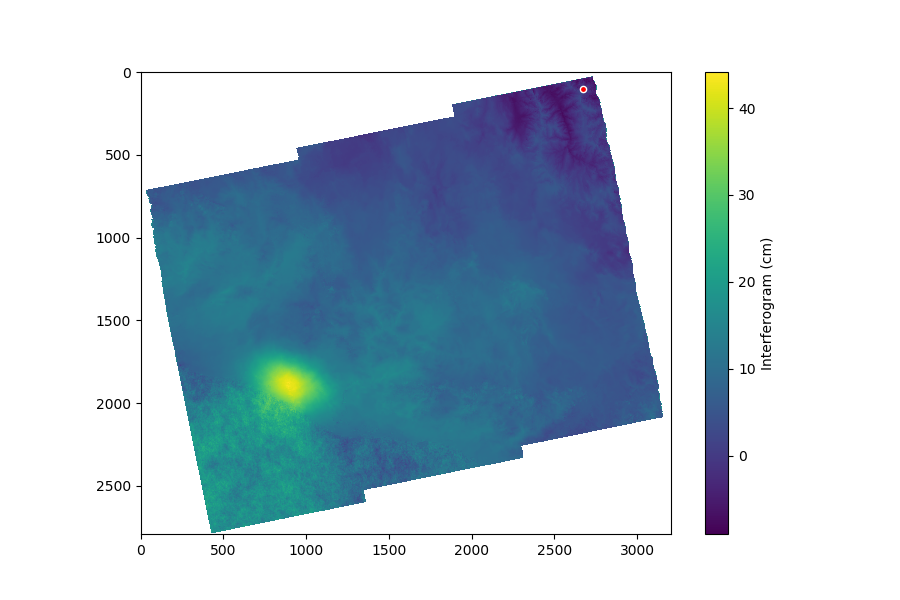

In [45]:
figure, subplot = plt.subplots(figsize = (9, 6))

image = plt.imshow(np.ma.masked_invalid(unw_data_array[image_index]),
                   cmap = 'viridis', interpolation = 'None', rasterized = True,
                   zorder = 0)

scatter = plt.scatter(reference_point[0], reference_point[1], s = 20, c = 'red', edgecolors = 'white')

image_colorbar = plt.colorbar(image)
image_colorbar.set_label('Interferogram (cm)')
                
plt.show()

In [46]:
georaster = create_georaster_from_array(unw_data_array,           
                                        geotransform, 
                                        projection,
                                        file_type = 'GTiff',
                                        file_path = data_folder + 'Stacked_Referenced_filt_topophase_unw_geo.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None

In [47]:
georaster = open_georaster(data_folder + 'Stacked_atmospheric_delay_model.tif')
atm_data_array = get_georaster_array(georaster)

In [48]:
atm_data_array -= atm_data_array[:, reference_point[1]:reference_point[1] + 1, reference_point[0]:reference_point[0] + 1]

<IPython.core.display.Javascript object>


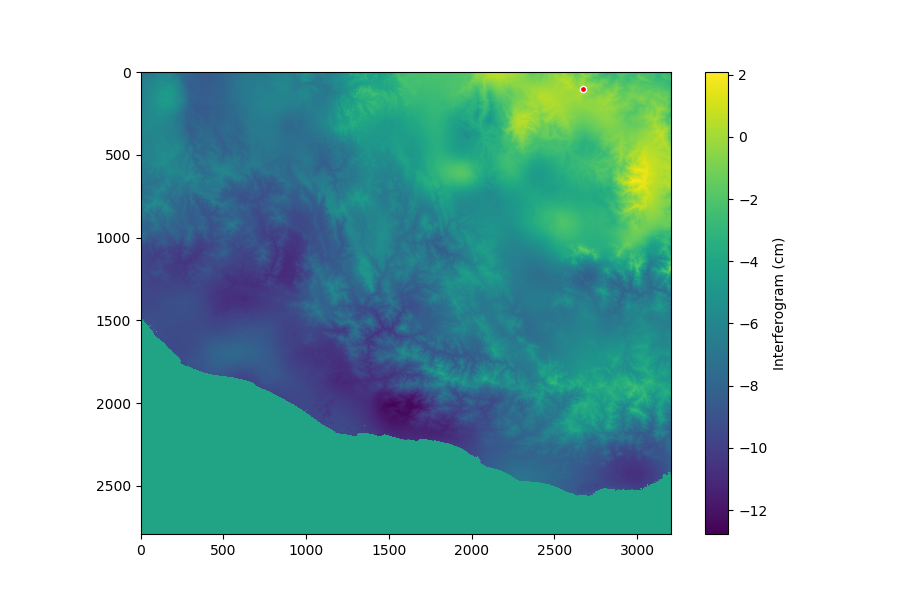

In [49]:
figure, subplot = plt.subplots(figsize = (9, 6))

image = plt.imshow(np.ma.masked_invalid(atm_data_array[image_index]),
                   cmap = 'viridis', interpolation = 'None', rasterized = True,
                   zorder = 0)

scatter = plt.scatter(reference_point[0], reference_point[1], s = 20, c = 'red', edgecolors = 'white')

image_colorbar = plt.colorbar(image)
image_colorbar.set_label('Interferogram (cm)')
                
plt.show()

In [50]:
georaster = create_georaster_from_array(atm_data_array,           
                                        geotransform, 
                                        projection,
                                        file_type = 'GTiff',
                                        file_path = data_folder + 'Stacked_Referenced_atmospheric_delay_model.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None

<IPython.core.display.Javascript object>


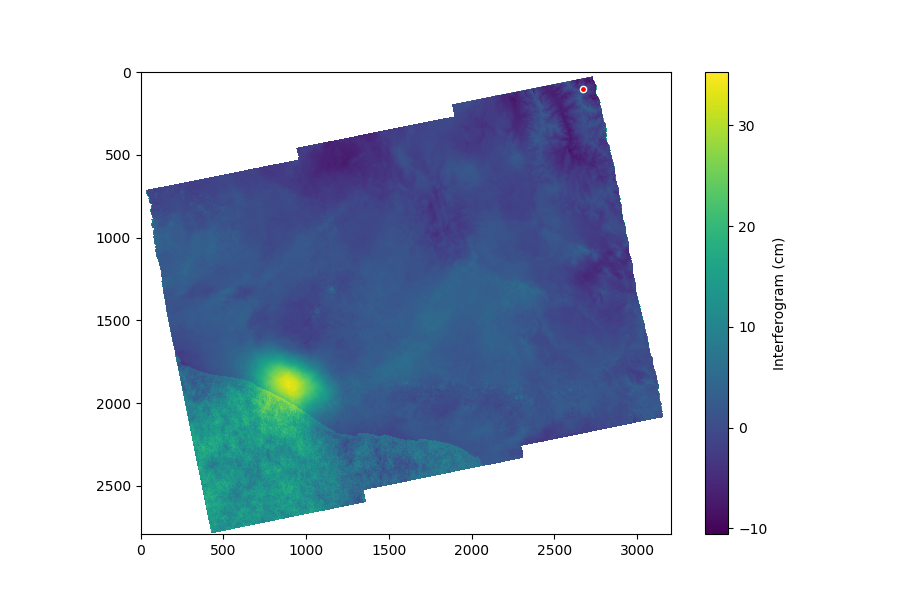

In [51]:
figure, subplot = plt.subplots(figsize = (9, 6))

image = plt.imshow(np.ma.masked_invalid(unw_data_array[image_index] + atm_data_array[image_index]),
                   cmap = 'viridis', interpolation = 'None', rasterized = True,
                   zorder = 0)

scatter = plt.scatter(reference_point[0], reference_point[1], s = 20, c = 'red', edgecolors = 'white')

image_colorbar = plt.colorbar(image)
image_colorbar.set_label('Interferogram (cm)')
                
plt.show()

In [52]:
georaster = create_georaster_from_array(unw_data_array + atm_data_array,           
                                        geotransform, 
                                        projection,
                                        file_type = 'GTiff',
                                        file_path = data_folder + 'Stacked_Referenced_filt_atmtopophase_unw_geo.tif',
                                        options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
georaster = None